## Model validation on the Iris dataset

In [2]:
#### PACKAGE IMPORTS ####
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection 
%matplotlib inline

#### The Iris dataset

In this assignment, you will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Your goal is to construct a neural network that classifies each sample into the correct class, as well as applying validation and regularisation techniques.

## Load Data

In [4]:
iris_data = datasets.load_iris() # Load Iris Data set
data = iris_data["data"]         # Get data
targets = iris_data["target"]    # Get target
    
### Make a test/train split ###
train_data, test_data, train_targets, test_targets = model_selection.train_test_split(data,targets,test_size=0.2)

### Convert targets to a one-hot encoding ###
train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

## Build the neural network model

##### Unregularized Model:
You can now construct a model to fit to the data. Using the Sequential API, build your model according to the following specifications:

* The model should use the `input_shape` in the function argument to set the input size in the first layer.
* The first layer should be a dense layer with 64 units.
* The weights of the first layer should be initialised with the He uniform initializer.
* The biases of the first layer should be all initially equal to one.
* There should then be a further four dense layers, each with 128 units.
* This should be followed with four dense layers, each with 64 units.
* All of these Dense layers should use the ReLU activation function.
* The output Dense layer should have 3 units and the softmax activation function.

In total, the network should have 10 layers.

##### Regularized Model:
You should now define a new regularised model.
The specs for the regularised model are the same as our original model, with the addition of two dropout layers, weight decay, and a batch normalisation layer. 

In particular:

* Add a dropout layer after the 3rd Dense layer
* Then there should be two more Dense layers with 128 units before a batch normalisation layer
* Following this, two more Dense layers with 64 units and then another Dropout layer
* Two more Dense layers with 64 units and then the final 3-way softmax layer
* Add weight decay (l2 kernel regularisation) in all Dense layers except the final softmax layer

In [47]:
### GET UNREGULARIZED MODEL ###
def get_model(input_shape):
    he= "glorot_uniform"
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer=he,bias_initializer='ones'))
    model.add(tf.keras.layers.Dense(units=128,activation='relu'))
    model.add(tf.keras.layers.Dense(units=128,activation='relu'))
    model.add(tf.keras.layers.Dense(units=128,activation='relu'))
    model.add(tf.keras.layers.Dense(units=128,activation='relu'))
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dense(units=3,activation='softmax'))
    
    return model

### GET REGULARIZED MODEL ###
def get_regularised_model(input_shape, dropout_rate, weight_decay):
    he= "glorot_uniform"
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer=he,bias_initializer='ones',input_shape=input_shape
                                   ,kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dropout(dropout_rate))               # Dropout
    model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.BatchNormalization())                # Batch Normalization
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dropout(dropout_rate))               # Dropout
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dense(units=3,activation='softmax'))
    
    return model
    
### COMPILE A MODEL ###
def compile_model(model):
    Adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
    model.compile(optimizer=Adam,loss="categorical_crossentropy",metrics=["acc"])
    
### TRAIN A MODEL ###
def train_model(model, train_data, train_targets, epochs,**kwargs):
    return  model.fit(train_data,train_targets,epochs=epochs,validation_split=0.15,batch_size=40,**kwargs)

### PLOT TRAINED MODEL HISTORY ###
def plot_train(history):
    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    try:
        axis[0].plot(history.history['accuracy'])
        axis[0].plot(history.history['val_accuracy'])
   
    except KeyError:
        axis[0].plot(history.history['acc'])
        axis[0].plot(history.history['val_acc'])
        
    axis[0].set_title('Accuracy vs. epochs')
    axis[0].set_ylabel('accuracy')
    axis[0].set_xlabel('Epoch')
    axis[0].legend(['Training', 'Validation'], loc='upper right')
    
    axis[1].plot(history.history['loss'])
    axis[1].plot(history.history['val_loss'])
    axis[1].set_title('Loss vs. epochs')
    axis[1].set_ylabel('Loss')
    axis[1].set_xlabel('Epoch')
    axis[1].legend(['Training', 'Validation'], loc='upper right')
    
    plt.show() 
    
# Evaluate the model on the test set
def evaluate_model(model):
    test_loss, test_acc = model.evaluate(test_data, test_targets, verbose=0)
    print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))


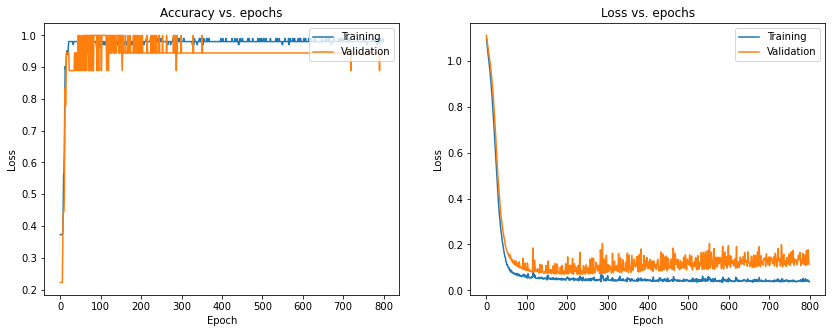

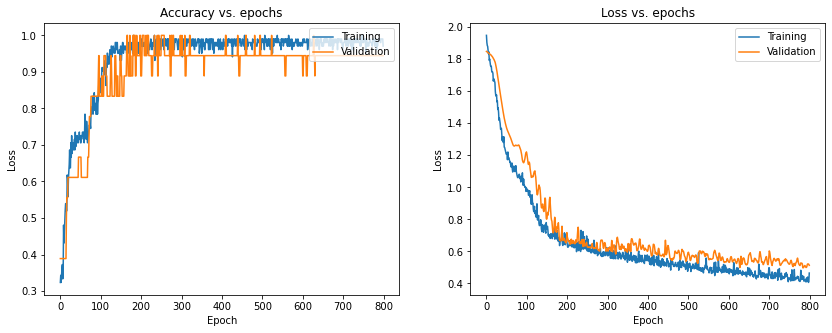

In [35]:
### UNREGULARIZED MODEL ###
model = get_model(train_data[0].shape)
compile_model(model)
history = train_model(model, train_data, train_targets, epochs=800, verbose=0)
plot_train(history)

### REGULARIZED MODEL ###
reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)
compile_model(reg_model)
reg_history = train_model(reg_model, train_data, train_targets, epochs=800, verbose=0)
plot_train(reg_history)

We can see that the regularisation has helped to reduce the overfitting of the network.
You will now incorporate callbacks into a new training run that implements early stopping and learning rate reduction on plateaux.

Fill in the function below so that:

* It creates an `EarlyStopping` callback object and a `ReduceLROnPlateau` callback object
* The early stopping callback is used and monitors validation loss with the mode set to `"min"` and patience of 30.
* The learning rate reduction on plateaux is used with a learning rate factor of 0.2 and a patience of 20.

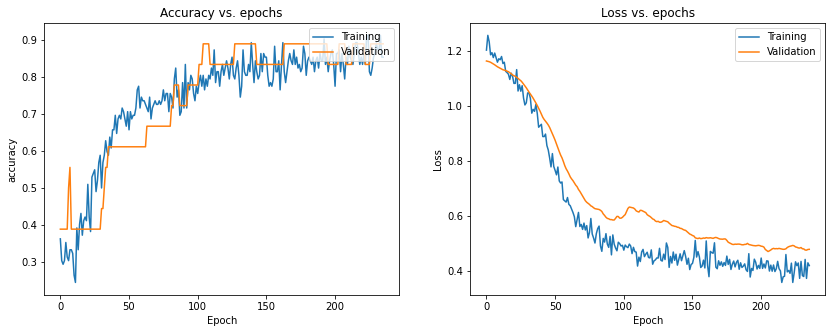

Test loss: 0.392
Test accuracy: 100.00%


In [49]:
### DEFINE CALLBACK PARAMETERS
def get_callbacks():
    call   = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,mode="min")
    plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=0, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)
    
    return call,plateau

### DEFINE CALL BACKS in Variables##
early_stopping, learning_rate_reduction = get_callbacks()

### CREATE UNREGULARIZED MODEL ###
call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001) # Get model
compile_model(call_model)                                            # Compile model
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0) # Train model

plot_train(call_history)   # Plot Model
evaluate_model(call_model) # Evaluate Model in Test set 